In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [23]:
df = pd.read_csv("Datasets/cleaned_data.csv")
df.head()

,Branch,Amount,Sender,Sender Old Balance,Sender New Balance,Receiver,Receiver Old Balance,Receiver New Balance,Transaction Count,Account Age,Last Transaction,Time of Transaction,isFraud
0,Fort Worth,6382.19,C1568949719,29458.84,23076.65,C1650299186,40246.02,46628.21,109,5.75,2.97,20:20:05,0
1,Austin,6064.70,C1406004470,70695.74,64631.04,C1868724762,51617.04,57681.74,6,7.75,1.10,07:38:27,0
2,Fort Worth,112501.19,C1807397140,128395.37,15894.18,C715093362,95301.35,207802.54,18,5.51,4.98,18:47:37,0
3,Nashville,2496.08,C919962315,55283.12,52787.04,C1875395688,89095.63,91591.71,7,5.35,1.50,00:29:40,0
4,San Francisco,12827.97,C88893820,91124.57,78296.60,C1266224518,44983.23,57811.20,12,7.09,2.61,17:05:16,0


In [24]:
df.drop(columns=['Time of Transaction'], inplace=True)

# Label encoding

In [25]:
df_encoded = df.copy()

In [26]:
encoder = {}
encoded_values = {}
for i in df.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    df_encoded[i] = encoder[i].fit_transform(df[i])

branch_mapping = dict(zip(encoder['Branch'].classes_, encoder['Branch'].transform(encoder['Branch'].classes_)))
sender_mapping = dict(zip(encoder['Sender'].classes_, encoder['Sender'].transform(encoder['Sender'].classes_)))
receiver_mapping = dict(zip(encoder['Receiver'].classes_, encoder['Receiver'].transform(encoder['Receiver'].classes_)))

In [27]:
with open("Encodings/branch_encoding.txt", 'w') as f:
    f.write(str(branch_mapping))

with open("Encodings/sender_encoding.txt", 'w') as f:
    f.write(str(sender_mapping))
    
with open("Encodings/receiver_encoding.txt", 'w') as f:
    f.write(str(receiver_mapping))

In [28]:
df_encoded.head()

,Branch,Amount,Sender,Sender Old Balance,Sender New Balance,Receiver,Receiver Old Balance,Receiver New Balance,Transaction Count,Account Age,Last Transaction,isFraud
0,8,6382.19,2408,29458.84,23076.65,3394,40246.02,46628.21,109,5.75,2.97,0
1,0,6064.70,1690,70695.74,64631.04,4534,51617.04,57681.74,6,7.75,1.10,0
2,8,112501.19,3431,128395.37,15894.18,8498,95301.35,207802.54,18,5.51,4.98,0
3,13,2496.08,7751,55283.12,52787.04,4572,89095.63,91591.71,7,5.35,1.50,0
4,19,12827.97,7617,91124.57,78296.60,1364,44983.23,57811.20,12,7.09,2.61,0


# Correlations

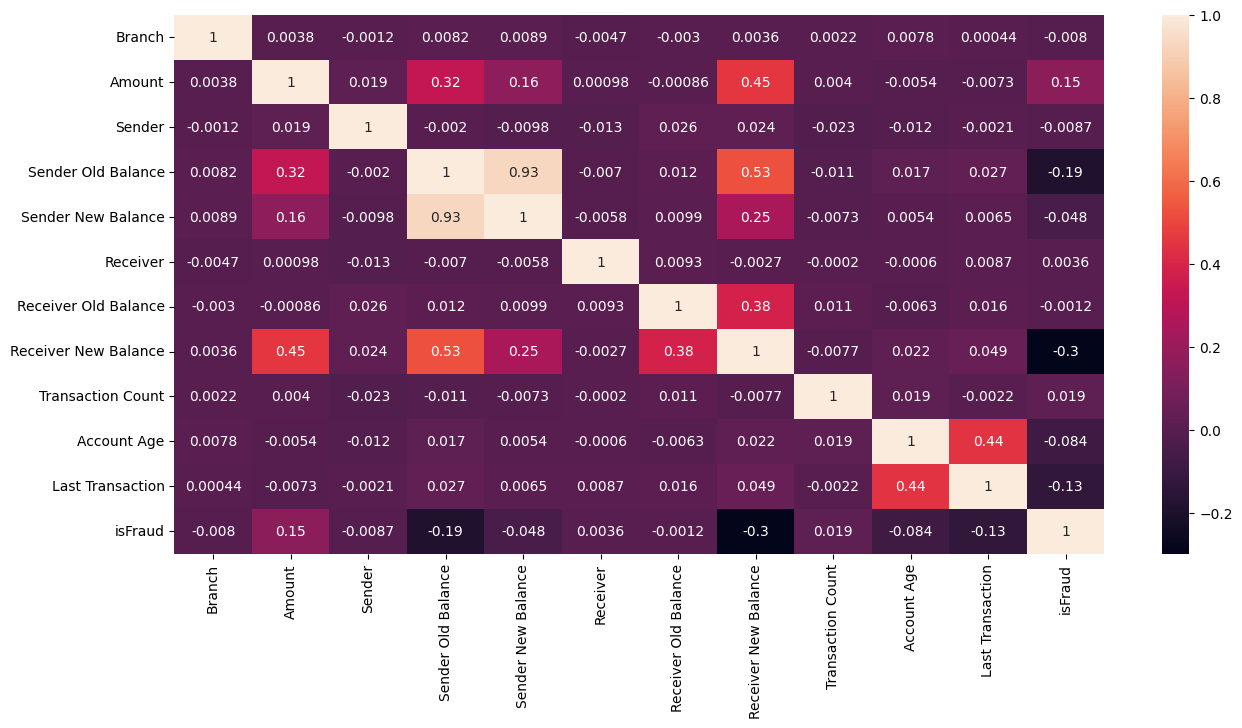

In [29]:
plt.figure(figsize=(15,7))
sns.heatmap(df_encoded.corr(),annot=True)
plt.show()

In [30]:
X = df_encoded.iloc[:,:-1]
y = df_encoded.iloc[:,-1]

# Testing models

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [32]:
metrics = pd.DataFrame(columns=["Model", "Train Accuracy", "Train Precision", "Train Recall", "Train F1", "Test Accuracy", "Test Precision", "Test Recall", "Test F1"])

In [33]:
models = {"Logistic Regression": LogisticRegression(max_iter=100000),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "SVM": SVC(kernel='linear', C=1.0)}

In [34]:
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

for model_name, model in models.items():
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(X_train_fold, y_train_fold)

        val_preds = model.predict(X_val_fold)
        
        val_accuracy = accuracy_score(y_val_fold, val_preds)
        val_precision = precision_score(y_val_fold, val_preds)
        val_recall = recall_score(y_val_fold, val_preds)
        val_f1 = f1_score(y_val_fold, val_preds)

        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
        recall_list.append(val_recall)
        f1_score_list.append(val_f1)
        
    mean_accuracy = np.mean(accuracy_list)
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)
    mean_f1_score = np.mean(f1_score_list)
    
    model.fit(X_train, y_train)
    
    test_preds = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds)
    test_recall = recall_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)

    metrics = metrics.append({"Model": model_name,
                              "Train Accuracy": mean_accuracy,
                              "Train Precision": mean_precision,
                              "Train Recall": mean_recall,
                              "Train F1": mean_f1_score,
                              "Test Accuracy": test_accuracy,
                              "Test Precision": test_precision,
                              "Test Recall": test_recall,
                              "Test F1": test_f1}, ignore_index=True)

C:\Users\shrut\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\shrut\AppData\Local\Temp\ipykernel_33588\3903626574.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Model": model_name,
C:\Users\shrut\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\shrut\AppData\Local\Temp\ipykernel_33588\3903626574.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Model": model_name,


In [ ]:
metrics

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Logistic Regression,0.956093,1.000000,0.775059,0.873277,0.942220,1.000000,0.723666,0.839683
1,Random Forest,1.000000,1.000000,1.000000,1.000000,0.955378,0.993139,0.792066,0.881279
2,XGBoost,1.000000,1.000000,1.000000,1.000000,0.976545,1.000000,0.887825,0.940580
3,Logistic Regression(Stratified),0.955006,1.000000,0.769407,0.868474,0.942220,1.000000,0.723666,0.839683
4,Random Forest(Stratified),0.963022,0.997214,0.812909,0.894859,0.955378,0.993139,0.792066,0.881279
5,XGBoost(Stratified),0.979816,0.997426,0.898934,0.945248,0.976545,1.000000,0.887825,0.940580


# Saving the model

In [ ]:
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
dwdwimport pickle
path = "prediction_model.pkl"
with open(path, 'wb') as f:
    pickle.dump(final_model,f)

SyntaxError: invalid syntax (302686973.py, line 1)